In [99]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [100]:
data = pd.read_csv('Merged_Data.csv', index_col = 'Date')
#data = data.iloc[:2665, :]
data

,CPI_CPI,XRP_Open,XRP_High,XRP_Low,XRP_Close,XRP_Adj Close,XRP_Volume,DJIA_DJIA,STICKY_STICKY,Ethereum_Open,...,VIX_LOW,VIX_CLOSE,real_interest_rate_10Y_real_interest_rate_10Y,SP500_SP500,BNB_Open,BNB_High,BNB_Low,BNB_Close,BNB_Adj Close,BNB_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-18,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17265.990000,1.954047,0.000000,...,11.980000,12.030000,0.580860,2011.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-19,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17279.740000,1.954047,0.000000,...,11.520000,12.110000,0.580860,2010.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-20,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17244.053333,1.954047,0.000000,...,12.056667,12.636667,0.580860,2005.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-21,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17208.366667,1.954047,0.000000,...,12.593333,13.163333,0.580860,1999.66,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-09-22,237.477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,17172.680000,1.954047,0.000000,...,13.130000,13.690000,0.580860,1994.29,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-07,302.918,0.503306,0.514165,0.499108,0.513736,0.513736,1.060409e+09,33535.900000,6.322749,1872.734131,...,18.495000,18.542500,1.443914,4107.07,312.453949,312.865265,309.983429,310.699493,310.699493,478098163.0
2023-04-08,302.918,0.513730,0.513730,0.504441,0.505716,0.505716,5.876411e+08,33552.773333,6.322749,1864.679077,...,18.640000,18.685000,1.443914,4107.75,310.665314,312.683258,310.388031,310.634735,310.634735,461767801.0
2023-04-09,302.918,0.505694,0.509143,0.500927,0.505834,0.505834,5.505828e+08,33569.646667,6.322749,1849.672241,...,18.785000,18.827500,1.443914,4108.43,310.659058,313.613159,309.884583,312.872253,312.872253,465627007.0


In [101]:
data['y'] = data['Bitcoin_Close']

x = data.iloc[:, :46].values
y = data.iloc[:, 46].values

split = int(data.shape[0]* 0.83)
train_x, test_x = x[: split, :], x[split - 20:, :]
train_y, test_y = y[: split, ], y[split - 20: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2596, 46) trainY: (2596,)
testX: (552, 46) testY: (552,)


In [102]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [103]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([46, 400, 400, 400, 10], 10)

[1/100] Loss: 713.2714672088623
[2/100] Loss: 646.833176612854
[3/100] Loss: 606.6203336715698
[4/100] Loss: 555.0330867767334
[5/100] Loss: 567.1654577255249
[6/100] Loss: 549.6728315353394
[7/100] Loss: 493.93757915496826
[8/100] Loss: 461.8380994796753
[9/100] Loss: 507.3960943222046
[10/100] Loss: 432.7610230445862
[11/100] Loss: 407.938467502594
[12/100] Loss: 419.473641872406
[13/100] Loss: 408.80601978302
[14/100] Loss: 376.6280879974365
[15/100] Loss: 338.6445231437683
[16/100] Loss: 317.07287216186523
[17/100] Loss: 319.3038215637207
[18/100] Loss: 295.02458477020264
[19/100] Loss: 254.93566608428955
[20/100] Loss: 241.23352336883545
[21/100] Loss: 244.27215003967285
[22/100] Loss: 244.96747207641602
[23/100] Loss: 234.4071125984192
[24/100] Loss: 212.43968772888184
[25/100] Loss: 187.57920503616333
[26/100] Loss: 176.09014511108398
[27/100] Loss: 190.04070138931274
[28/100] Loss: 202.5022578239441
[29/100] Loss: 176.13698720932007
[30/100] Loss: 146.17570853233337
[31/100] Lo

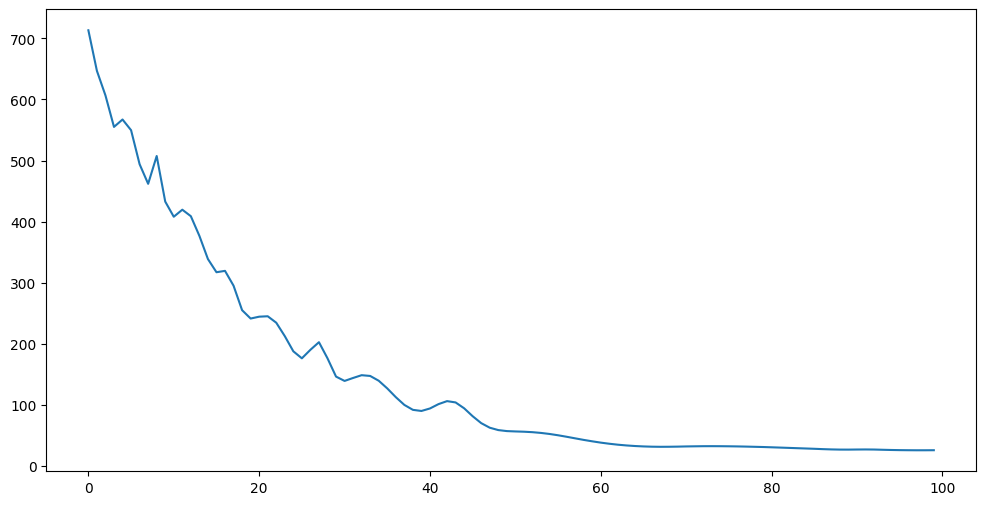

In [104]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 100 # plot shows 200 yields lowest loss
learning_rate = 0.0001
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [105]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [106]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [107]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [108]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2593, 3, 56]) train_y: torch.Size([2593, 1]) train_y_gan: torch.Size([2593, 4, 1])
test_x: torch.Size([549, 3, 56]) test_y: torch.Size([549, 1]) test_y_gan: torch.Size([549, 4, 1])


In [109]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [110]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
#learning_rate = 0.000115
learning_rate = 0.000115
num_epochs = 200 #100
critic_iterations = 5
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(56).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())
    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/200] LossD: -0.0046761855483055115 LossG:-0.5451342277228832
[2/200] LossD: -0.008065463975071907 LossG:-0.4557633027434349
[3/200] LossD: -0.009764358401298523 LossG:-0.3789765853434801
[4/200] LossD: -0.009689646773040295 LossG:-0.3103969395160675
[5/200] LossD: -0.006762833334505558 LossG:-0.24381086695939302
[6/200] LossD: -0.0030875597149133682 LossG:-0.174552783370018
[7/200] LossD: -4.793237894773483e-05 LossG:-0.11796835996210575
[8/200] LossD: 0.0006165888626128435 LossG:-0.06382489879615605
[9/200] LossD: -7.632639608345926e-05 LossG:-0.020772538613528013
[10/200] LossD: -0.0011268690432189032 LossG:-0.0009466907415571768
[11/200] LossD: -0.0018747415160760283 LossG:0.012131857307394966
[12/200] LossD: -0.0027460877900011837 LossG:0.019540743553079665
[13/200] LossD: -0.003349207923747599 LossG:0.0300920398440212
[14/200] LossD: -0.0039112603990361094 LossG:0.034998483140952885
[15/200] LossD: -0.004615198937244713 LossG:0.03639031725469977
[16/200] LossD: -0.0053677189862

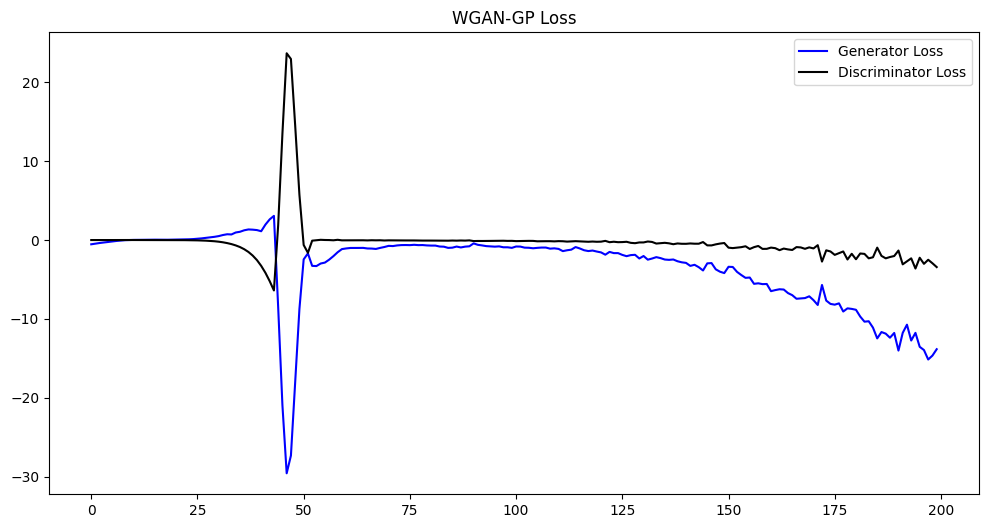

In [111]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.legend(loc = 'upper right')
plt.savefig(f'WGAN-GP Loss.png', dpi=300)

In [112]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:5985.188388496045


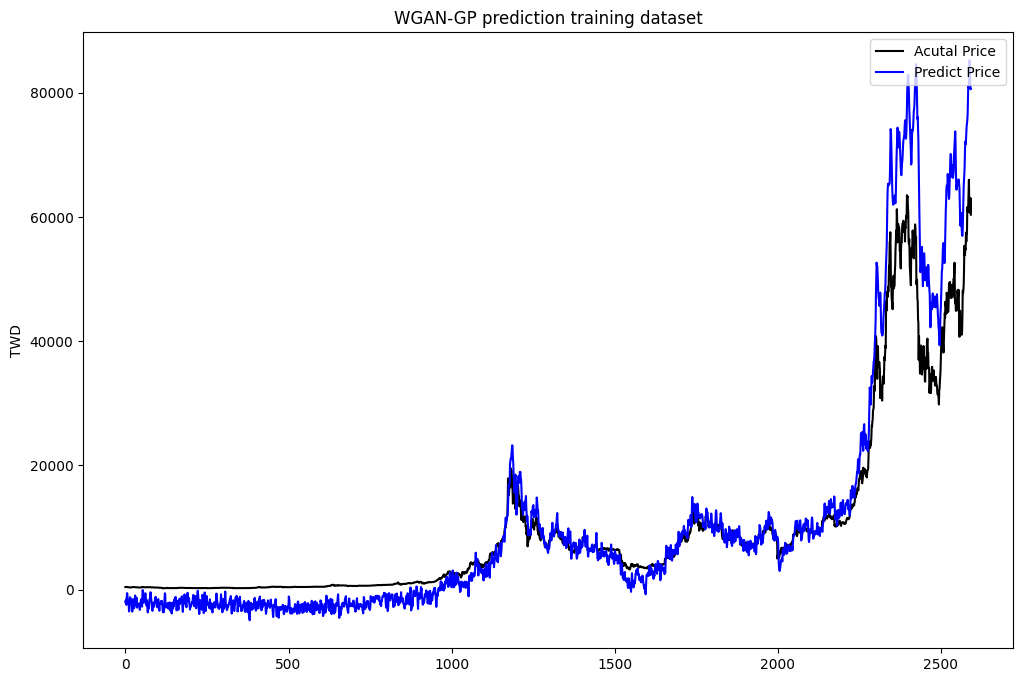

In [113]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('TWD')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:11226.876039417637


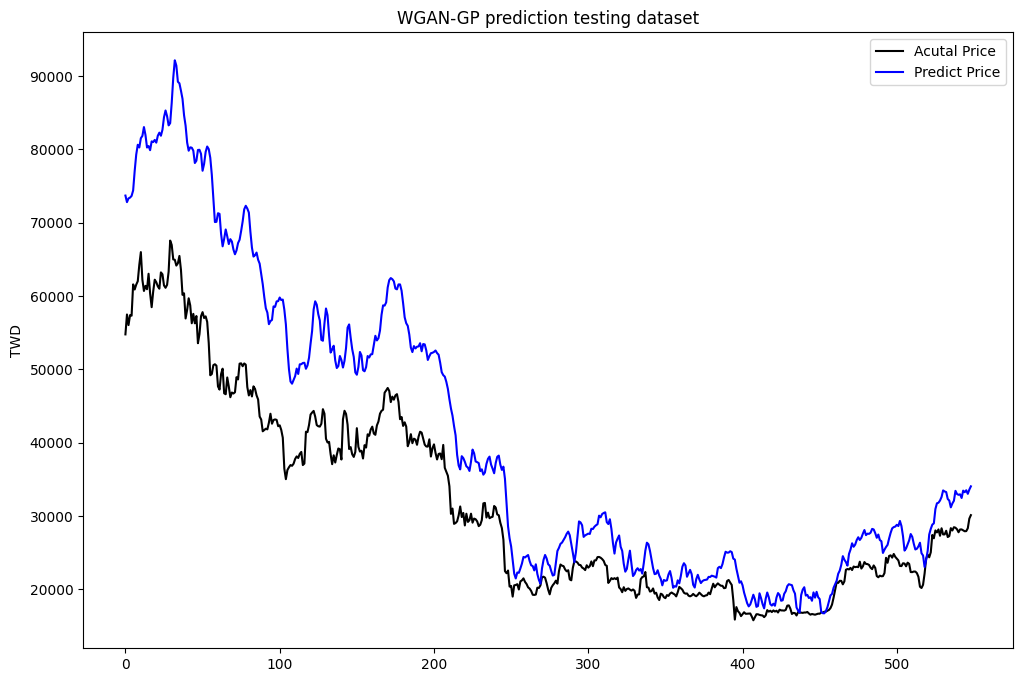

In [114]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('TWD')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')